In [1]:
##This code predicts which of the user profiles with listings in a housing website is a scammer. This dataset is a skewed dataset
#which means the number of entries with y=0 (not a scammer) is much more than y=1 (is a scammer). Therefore I am using F1 score
#as a metric to benchmark the model performance. I am using first a simple logistic regression model and then a more involved
#neural network model

import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [2]:
#Loading dataset
missing_values = ['na','--','?','-','None','none','non','null','NaN','']
X_train_temp = pd.read_csv('HA_Data_Science_Train.csv',na_values=missing_values)

In [3]:
X_train_temp.shape


(16762, 15)

In [4]:
X_train_temp.head(10)


,LISTING_KIND,LISTING_CITY,LISTING_PRICE,IS_ARCHIVED,ARCHIVE_REASON,LOGIN_COUNTRY_CODE,LISTING_COUNTRY_CODE,LISTING_REGISTRATION_POSSIBLE,ADVERTISER_COMPLETENESS_SCORE,MANAGED_ACCOUNT,HAS_PROFILE_PIC,BROWSER,OS,IS_SCAMMER,ANONYMISED_EMAIL
0,1,Göteborg,725.00,False,NaN,se,se,0,80,False,1,Mobile Safari,iOS,0,bosqlqg@aol.com
1,1,Göteborg,469.35,False,NaN,se,se,1,70,False,1,Chrome,Android,0,fylm235670@gmail.com
2,1,Elche,200.00,False,NaN,es,es,0,25,False,0,Chrome,Android,0,mhzasjonfobc@gmail.com
3,0,Verona,1500.00,False,NaN,it,it,0,86,False,1,Chrome,Mac OS X,0,uclypkijb@italianflat.com
4,1,Copenhagen,904.16,False,NaN,dk,dk,0,5,False,1,Microsoft Edge,Windows,0,dyrrtatzx.fhcs@outlook.com
5,0,Nice,1900.00,False,NaN,it,fr,0,50,False,1,Chrome,Windows,0,tahfbqk.ovgb@gmail.com
6,1,Elche,175.00,False,NaN,es,es,0,40,False,0,Chrome,Windows,0,ipeoq@jjvela.net
7,1,Elche,160.00,False,NaN,ar,es,1,45,False,1,Safari,Mac OS X,0,qroaqfdgld@gmail.com
8,0,Verona,1500.00,False,NaN,it,it,0,86,False,1,Chrome,Android,0,pumhmmkgy@italianflat.com
9,0,Copenhagen,205.75,True,NaN,dk,dk,1,5,False,0,Chrome,Android,0,nbgmjktjkt@hotmail.com


In [5]:
X_train_temp.IS_ARCHIVED.dtype

dtype('bool')

In [6]:
count_y_ones = (X_train_temp['IS_SCAMMER']==1).to_numpy()

In [7]:
#counting the number of 'IS_SCAMMER=1 entries'
print(np.sum(count_y_ones))

970


In [8]:
#counting number of entries with 'nan' for different columns
print(X_train_temp['BROWSER'].isna().sum())
print(X_train_temp['OS'].isna().sum())
print(X_train_temp['LOGIN_COUNTRY_CODE'].isna().sum())
print(X_train_temp['LISTING_COUNTRY_CODE'].isna().sum())

885
885
30
0


In [9]:
X_train = X_train_temp.copy()

In [10]:
X_train.BROWSER.fillna('uknown',inplace=True)
X_train.OS.fillna('unknown',inplace=True)

In [11]:
#converting columns to categorical variables 
X_train['BROWSER']=X_train['BROWSER'].astype('category')
X_train['OS']=X_train['OS'].astype('category')
X_train['LOGIN_COUNTRY_CODE']=X_train['LOGIN_COUNTRY_CODE'].astype('category')
X_train['LISTING_COUNTRY_CODE']=X_train['LISTING_COUNTRY_CODE'].astype('category')


In [12]:
#making a list of categories for different columns
browsers = list(X_train['BROWSER'].dtype.categories)
os = list(X_train['OS'].dtype.categories)
login_countries =list(X_train['LOGIN_COUNTRY_CODE'].dtype.categories)
listing_countries = list(X_train['LISTING_COUNTRY_CODE'].dtype.categories)

In [13]:
print(browsers)

['Android Mobile', 'BlackBerry', 'Chrome', 'Chrome iOS', 'Facebook Mobile', 'Firefox', 'Firefox iOS', 'Internet Explorer', 'Internet Explorer Mobile', 'Microsoft Edge', 'Mobile Safari', 'Mozilla', 'Opera', 'Safari', 'uknown']


In [14]:
print(os)

['Android', 'BlackBerry', 'Chrome OS', 'Linux', 'Mac OS X', 'Windows', 'Windows Phone', 'iOS', 'unknown']


In [15]:
print(login_countries)

['ad', 'ae', 'al', 'am', 'ar', 'at', 'au', 'aw', 'az', 'ba', 'bd', 'be', 'bf', 'bg', 'bh', 'bj', 'br', 'ca', 'cd', 'ch', 'cl', 'cm', 'cn', 'co', 'cr', 'cw', 'cy', 'cz', 'de', 'dk', 'do', 'dz', 'ec', 'ee', 'eg', 'es', 'fi', 'fj', 'fr', 'gb', 'ge', 'gr', 'gt', 'hk', 'hr', 'ht', 'hu', 'id', 'ie', 'il', 'in', 'iq', 'is', 'it', 'jm', 'jo', 'jp', 'ke', 'kg', 'kh', 'kr', 'kw', 'la', 'lb', 'lk', 'lt', 'lu', 'lv', 'ma', 'mc', 'md', 'me', 'mn', 'mq', 'mt', 'mu', 'mx', 'my', 'ng', 'nl', 'no', 'np', 'nz', 'pa', 'pe', 'ph', 'pk', 'pl', 'ps', 'pt', 'qa', 're', 'ro', 'rs', 'ru', 'se', 'sg', 'si', 'sk', 'sm', 'sr', 'sx', 'th', 'tn', 'tr', 'tw', 'tz', 'ua', 'ug', 'us', 'uy', 'uz', 've', 'vn', 'za']


In [16]:
print(listing_countries)

['ae', 'al', 'am', 'ar', 'at', 'au', 'aw', 'az', 'ba', 'bd', 'be', 'bg', 'br', 'bw', 'ca', 'ch', 'cl', 'cn', 'co', 'cr', 'cu', 'cy', 'cz', 'de', 'dk', 'do', 'dz', 'ec', 'ee', 'eg', 'es', 'fi', 'fj', 'fr', 'gb', 'ge', 'gh', 'gp', 'gr', 'gt', 'hk', 'hr', 'hu', 'id', 'ie', 'il', 'in', 'ir', 'is', 'it', 'jm', 'jo', 'ke', 'kg', 'lk', 'lt', 'lu', 'lv', 'ma', 'md', 'mn', 'mt', 'mu', 'mx', 'my', 'ng', 'nl', 'no', 'np', 'nz', 'pa', 'pe', 'ph', 'pl', 'pt', 'qa', 'ro', 'ru', 'rw', 'se', 'sg', 'si', 'sk', 'sr', 'th', 'tn', 'tr', 'tw', 'tz', 'ua', 'ug', 'us', 'uy', 'uz', 'vn', 'za']


In [17]:
print(browsers)

['Android Mobile', 'BlackBerry', 'Chrome', 'Chrome iOS', 'Facebook Mobile', 'Firefox', 'Firefox iOS', 'Internet Explorer', 'Internet Explorer Mobile', 'Microsoft Edge', 'Mobile Safari', 'Mozilla', 'Opera', 'Safari', 'uknown']


In [18]:
print(X_train)


       LISTING_KIND LISTING_CITY  LISTING_PRICE  IS_ARCHIVED ARCHIVE_REASON  \
0                 1     Göteborg         725.00        False            NaN   
1                 1     Göteborg         469.35        False            NaN   
2                 1        Elche         200.00        False            NaN   
3                 0       Verona        1500.00        False            NaN   
4                 1   Copenhagen         904.16        False            NaN   
...             ...          ...            ...          ...            ...   
16757             0     Helsinki        1500.00        False            NaN   
16758             0       Vienna        1500.00        False            NaN   
16759             1       Vienna         550.00        False            NaN   
16760             1       Vienna         550.00        False            NaN   
16761             1       Vienna         470.00        False            NaN   

      LOGIN_COUNTRY_CODE LISTING_COUNTRY_CODE  LIST

In [19]:
X_is_scammer = X_train[X_train['IS_SCAMMER']==1]
X_not_scammer = X_train[X_train['IS_SCAMMER']==0]

<AxesSubplot:>

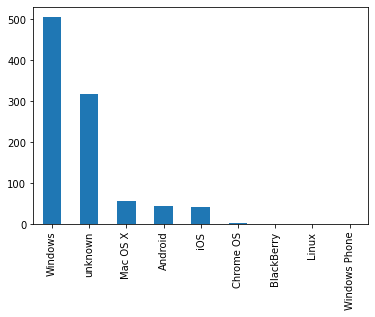

In [20]:
X_is_scammer['OS'].value_counts().plot(kind='bar')

<AxesSubplot:>

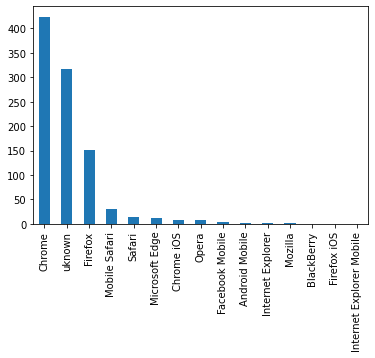

In [21]:
X_is_scammer['BROWSER'].value_counts().plot(kind='bar')

<AxesSubplot:xlabel='IS_SCAMMER', ylabel='count'>

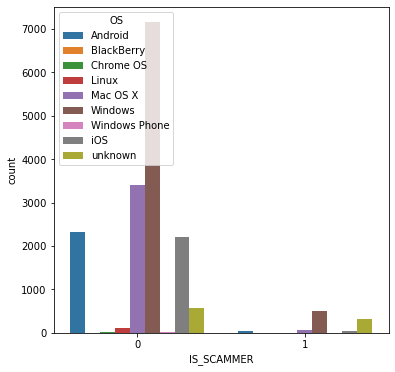

In [22]:
a4_dims = (6, 6)
fig, ax = plt.subplots(figsize=a4_dims)
sns.countplot(ax=ax,x='IS_SCAMMER',hue='OS',data=X_train)

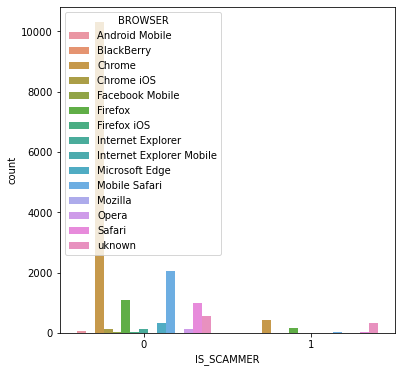

In [23]:
fig, ax = plt.subplots(figsize=a4_dims)
sns_plot=sns.countplot(ax=ax,x='IS_SCAMMER',hue='BROWSER',data=X_train)

In [24]:
browser_counts_is_scammer = X_is_scammer['BROWSER'].value_counts()
os_counts_is_scammer = X_is_scammer['OS'].value_counts()

In [25]:
print(browser_counts_is_scammer)

Chrome                      424
uknown                      317
Firefox                     152
Mobile Safari                30
Safari                       14
Microsoft Edge               11
Chrome iOS                    8
Opera                         7
Facebook Mobile               4
Android Mobile                1
Internet Explorer             1
Mozilla                       1
BlackBerry                    0
Firefox iOS                   0
Internet Explorer Mobile      0
Name: BROWSER, dtype: int64


In [26]:
login_country_counts_is_scammer = X_is_scammer['LOGIN_COUNTRY_CODE'].value_counts()
login_country_counts_not_scammer = X_not_scammer['LOGIN_COUNTRY_CODE'].value_counts()

In [27]:
print(login_country_counts_not_scammer[0:20])

nl    2615
es    2585
it    2486
de    1825
at    1061
be     825
us     441
fr     377
gb     319
se     305
is     255
pt     211
fi     179
dk     134
ie     131
mx     128
si     118
vn     115
gr     106
ca     104
Name: LOGIN_COUNTRY_CODE, dtype: int64


In [28]:
login_country_counts_not_scammer.index


CategoricalIndex(['nl', 'es', 'it', 'de', 'at', 'be', 'us', 'fr', 'gb', 'se',
                  ...
                  'la', 'sx', 'mn', 'sm', 'bf', 'bh', 'mc', 'lt', 'ng', 'mq'],
                 categories=['ad', 'ae', 'al', 'am', 'ar', 'at', 'au', 'aw', ...], ordered=False, dtype='category', length=115)

In [29]:
login_countries_list = list(login_country_counts_is_scammer.index)

In [30]:
##creating a smaller list of login countries
login_countries_list_small = login_countries_list[0:16]


In [31]:
print(login_countries_list_small)

['us', 'nl', 'de', 'fr', 'gb', 'ng', 'es', 'be', 'gr', 'au', 'at', 'ca', 'pt', 'ph', 'it', 'my']


In [32]:
#Keeping login country same if present in above list else replace by 'other'
X_train['LOGIN_COUNTRY_CODE']=[x if x in login_countries_list_small else 'other' for x in X_train['LOGIN_COUNTRY_CODE']]

In [33]:
X_train['LISTING_COUNTRY_CODE']=[x if x in login_countries_list_small else 'other' for x in X_train['LISTING_COUNTRY_CODE']]

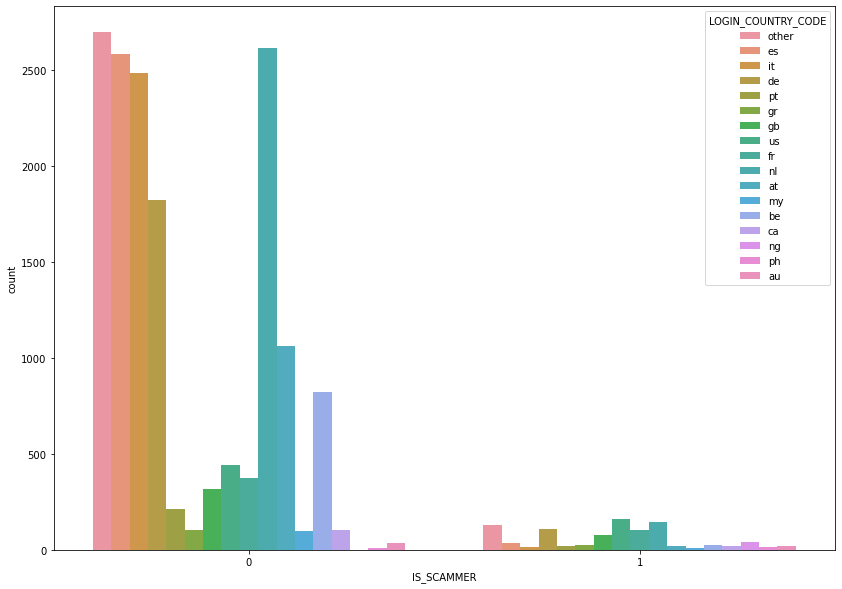

In [34]:
a4_dims = (14, 10)
fig, ax = plt.subplots(figsize=a4_dims)
sns_plot=sns.countplot(ax=ax,x='IS_SCAMMER',hue='LOGIN_COUNTRY_CODE',data=X_train)

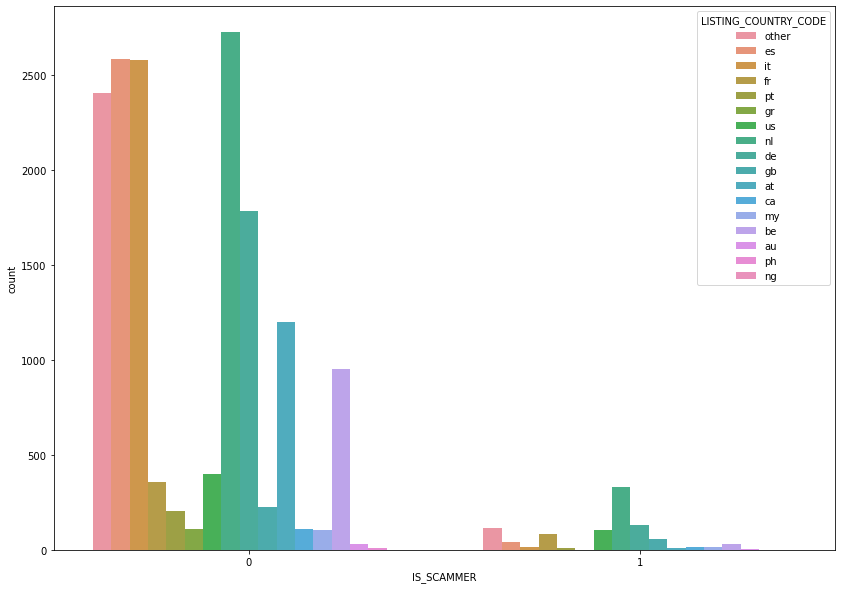

In [35]:
a4_dims = (14, 10)
fig, ax = plt.subplots(figsize=a4_dims)
sns_plot=sns.countplot(ax=ax,x='IS_SCAMMER',hue='LISTING_COUNTRY_CODE',data=X_train)

In [36]:
#Creating a additional Boolean column which is 1 of login and listing countries are same else 0.
X_train['login_equals_listing'] = X_train['LOGIN_COUNTRY_CODE']==X_train['LISTING_COUNTRY_CODE']

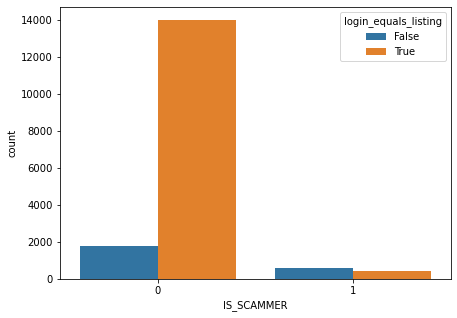

In [37]:
#in the plot below we see that probability for being a scammer is higher when login_equals_listing is false compared to when it
#is true
a4_dims = (7, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns_plot=sns.countplot(ax=ax,x='IS_SCAMMER',hue='login_equals_listing',data=X_train)

(0.0, 200000.0)

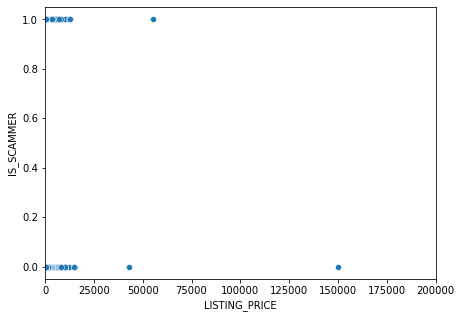

In [38]:
a4_dims = (7,5)
fig,ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(x='LISTING_PRICE',y='IS_SCAMMER',data=X_train,ax=ax)
ax.set_xlim(0,200000)

<AxesSubplot:xlabel='ADVERTISER_COMPLETENESS_SCORE', ylabel='IS_SCAMMER'>

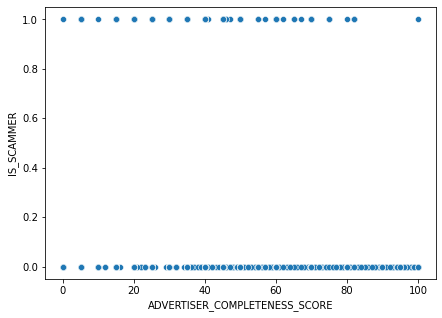

In [39]:
fig,ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(x='ADVERTISER_COMPLETENESS_SCORE',y='IS_SCAMMER',data=X_train)

In [40]:
X_train

,LISTING_KIND,LISTING_CITY,LISTING_PRICE,IS_ARCHIVED,ARCHIVE_REASON,LOGIN_COUNTRY_CODE,LISTING_COUNTRY_CODE,LISTING_REGISTRATION_POSSIBLE,ADVERTISER_COMPLETENESS_SCORE,MANAGED_ACCOUNT,HAS_PROFILE_PIC,BROWSER,OS,IS_SCAMMER,ANONYMISED_EMAIL,login_equals_listing
0,1,Göteborg,725.00,False,NaN,other,other,0,80,False,1,Mobile Safari,iOS,0,bosqlqg@aol.com,True
1,1,Göteborg,469.35,False,NaN,other,other,1,70,False,1,Chrome,Android,0,fylm235670@gmail.com,True
2,1,Elche,200.00,False,NaN,es,es,0,25,False,0,Chrome,Android,0,mhzasjonfobc@gmail.com,True
3,0,Verona,1500.00,False,NaN,it,it,0,86,False,1,Chrome,Mac OS X,0,uclypkijb@italianflat.com,True
4,1,Copenhagen,904.16,False,NaN,other,other,0,5,False,1,Microsoft Edge,Windows,0,dyrrtatzx.fhcs@outlook.com,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16757,0,Helsinki,1500.00,False,NaN,other,other,0,45,False,1,Chrome,Mac OS X,0,ohkmiavl144@hotmail.com,True
16758,0,Vienna,1500.00,False,NaN,other,at,1,50,False,1,Mobile Safari,iOS,0,aolvawikf@gmail.com,False
16759,1,Vienna,550.00,False,NaN,at,at,0,5,False,0,Chrome,Android,0,ofgvctiazalcopk@gmail.com,True
16760,1,Vienna,550.00,False,NaN,at,at,1,10,False,0,Chrome,Android,0,mfoapmfalqu@gmail.com,True


In [41]:
#converting categorical columns into numerical
X_train['login_equals_listing']=X_train['login_equals_listing'].astype('category').cat.codes
X_train['MANAGED_ACCOUNT']=X_train['MANAGED_ACCOUNT'].astype('category').cat.codes
#Converting %completenss score into a fraction
X_train['ADVERTISER_COMPLETENESS_SCORE']=X_train['ADVERTISER_COMPLETENESS_SCORE']/100


In [42]:
X_train

,LISTING_KIND,LISTING_CITY,LISTING_PRICE,IS_ARCHIVED,ARCHIVE_REASON,LOGIN_COUNTRY_CODE,LISTING_COUNTRY_CODE,LISTING_REGISTRATION_POSSIBLE,ADVERTISER_COMPLETENESS_SCORE,MANAGED_ACCOUNT,HAS_PROFILE_PIC,BROWSER,OS,IS_SCAMMER,ANONYMISED_EMAIL,login_equals_listing
0,1,Göteborg,725.00,False,NaN,other,other,0,0.80,0,1,Mobile Safari,iOS,0,bosqlqg@aol.com,1
1,1,Göteborg,469.35,False,NaN,other,other,1,0.70,0,1,Chrome,Android,0,fylm235670@gmail.com,1
2,1,Elche,200.00,False,NaN,es,es,0,0.25,0,0,Chrome,Android,0,mhzasjonfobc@gmail.com,1
3,0,Verona,1500.00,False,NaN,it,it,0,0.86,0,1,Chrome,Mac OS X,0,uclypkijb@italianflat.com,1
4,1,Copenhagen,904.16,False,NaN,other,other,0,0.05,0,1,Microsoft Edge,Windows,0,dyrrtatzx.fhcs@outlook.com,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16757,0,Helsinki,1500.00,False,NaN,other,other,0,0.45,0,1,Chrome,Mac OS X,0,ohkmiavl144@hotmail.com,1
16758,0,Vienna,1500.00,False,NaN,other,at,1,0.50,0,1,Mobile Safari,iOS,0,aolvawikf@gmail.com,0
16759,1,Vienna,550.00,False,NaN,at,at,0,0.05,0,0,Chrome,Android,0,ofgvctiazalcopk@gmail.com,1
16760,1,Vienna,550.00,False,NaN,at,at,1,0.10,0,0,Chrome,Android,0,mfoapmfalqu@gmail.com,1


In [43]:
mean_price = X_train.LISTING_PRICE.mean()
stddev = X_train.LISTING_PRICE.std()

In [44]:
#Standardizing the lsiting price
X_train['LISTING_PRICE']=(X_train['LISTING_PRICE']-mean_price)/stddev


In [45]:
X_train

,LISTING_KIND,LISTING_CITY,LISTING_PRICE,IS_ARCHIVED,ARCHIVE_REASON,LOGIN_COUNTRY_CODE,LISTING_COUNTRY_CODE,LISTING_REGISTRATION_POSSIBLE,ADVERTISER_COMPLETENESS_SCORE,MANAGED_ACCOUNT,HAS_PROFILE_PIC,BROWSER,OS,IS_SCAMMER,ANONYMISED_EMAIL,login_equals_listing
0,1,Göteborg,-0.021417,False,NaN,other,other,0,0.80,0,1,Mobile Safari,iOS,0,bosqlqg@aol.com,1
1,1,Göteborg,-0.053959,False,NaN,other,other,1,0.70,0,1,Chrome,Android,0,fylm235670@gmail.com,1
2,1,Elche,-0.088245,False,NaN,es,es,0,0.25,0,0,Chrome,Android,0,mhzasjonfobc@gmail.com,1
3,0,Verona,0.077236,False,NaN,it,it,0,0.86,0,1,Chrome,Mac OS X,0,uclypkijb@italianflat.com,1
4,1,Copenhagen,0.001389,False,NaN,other,other,0,0.05,0,1,Microsoft Edge,Windows,0,dyrrtatzx.fhcs@outlook.com,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16757,0,Helsinki,0.077236,False,NaN,other,other,0,0.45,0,1,Chrome,Mac OS X,0,ohkmiavl144@hotmail.com,1
16758,0,Vienna,0.077236,False,NaN,other,at,1,0.50,0,1,Mobile Safari,iOS,0,aolvawikf@gmail.com,0
16759,1,Vienna,-0.043693,False,NaN,at,at,0,0.05,0,0,Chrome,Android,0,ofgvctiazalcopk@gmail.com,1
16760,1,Vienna,-0.043693,False,NaN,at,at,1,0.10,0,0,Chrome,Android,0,mfoapmfalqu@gmail.com,1


In [46]:
#Calculating one-hot vectors for OS and BROWSER
OS_onehot = pd.get_dummies(X_train['OS'],prefix='OS')
BROWSER_onehot = pd.get_dummies(X_train['BROWSER'],prefix='BROWSER')


In [47]:
BROWSER_onehot

,BROWSER_Android Mobile,BROWSER_BlackBerry,BROWSER_Chrome,BROWSER_Chrome iOS,BROWSER_Facebook Mobile,BROWSER_Firefox,BROWSER_Firefox iOS,BROWSER_Internet Explorer,BROWSER_Internet Explorer Mobile,BROWSER_Microsoft Edge,BROWSER_Mobile Safari,BROWSER_Mozilla,BROWSER_Opera,BROWSER_Safari,BROWSER_uknown
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16757,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
16758,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
16759,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
16760,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [48]:
OS_onehot

,OS_Android,OS_BlackBerry,OS_Chrome OS,OS_Linux,OS_Mac OS X,OS_Windows,OS_Windows Phone,OS_iOS,OS_unknown
0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
16757,0,0,0,0,1,0,0,0,0
16758,0,0,0,0,0,0,0,1,0
16759,1,0,0,0,0,0,0,0,0
16760,1,0,0,0,0,0,0,0,0


In [49]:
#One-hot vectors for login and listing countries
LOGIN_onehot = pd.get_dummies(X_train['LOGIN_COUNTRY_CODE'],prefix='LOGIN')
LISTING_onehot = pd.get_dummies(X_train['LISTING_COUNTRY_CODE'],prefix='LISTING')

In [50]:
LISTING_onehot

,LISTING_at,LISTING_au,LISTING_be,LISTING_ca,LISTING_de,LISTING_es,LISTING_fr,LISTING_gb,LISTING_gr,LISTING_it,LISTING_my,LISTING_ng,LISTING_nl,LISTING_other,LISTING_ph,LISTING_pt,LISTING_us
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16757,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
16758,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16759,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16760,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [51]:
X_train = pd.concat([X_train,OS_onehot,BROWSER_onehot,LOGIN_onehot,LISTING_onehot],axis=1)

In [52]:
X_train


,LISTING_KIND,LISTING_CITY,LISTING_PRICE,IS_ARCHIVED,ARCHIVE_REASON,LOGIN_COUNTRY_CODE,LISTING_COUNTRY_CODE,LISTING_REGISTRATION_POSSIBLE,ADVERTISER_COMPLETENESS_SCORE,MANAGED_ACCOUNT,...,LISTING_gb,LISTING_gr,LISTING_it,LISTING_my,LISTING_ng,LISTING_nl,LISTING_other,LISTING_ph,LISTING_pt,LISTING_us
0,1,Göteborg,-0.021417,False,NaN,other,other,0,0.80,0,...,0,0,0,0,0,0,1,0,0,0
1,1,Göteborg,-0.053959,False,NaN,other,other,1,0.70,0,...,0,0,0,0,0,0,1,0,0,0
2,1,Elche,-0.088245,False,NaN,es,es,0,0.25,0,...,0,0,0,0,0,0,0,0,0,0
3,0,Verona,0.077236,False,NaN,it,it,0,0.86,0,...,0,0,1,0,0,0,0,0,0,0
4,1,Copenhagen,0.001389,False,NaN,other,other,0,0.05,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16757,0,Helsinki,0.077236,False,NaN,other,other,0,0.45,0,...,0,0,0,0,0,0,1,0,0,0
16758,0,Vienna,0.077236,False,NaN,other,at,1,0.50,0,...,0,0,0,0,0,0,0,0,0,0
16759,1,Vienna,-0.043693,False,NaN,at,at,0,0.05,0,...,0,0,0,0,0,0,0,0,0,0
16760,1,Vienna,-0.043693,False,NaN,at,at,1,0.10,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
X_train = X_train.drop(['LISTING_CITY','IS_ARCHIVED','ARCHIVE_REASON','ANONYMISED_EMAIL','OS','BROWSER','LOGIN_COUNTRY_CODE','LISTING_COUNTRY_CODE'],axis=1)

In [54]:
X_train


,LISTING_KIND,LISTING_PRICE,LISTING_REGISTRATION_POSSIBLE,ADVERTISER_COMPLETENESS_SCORE,MANAGED_ACCOUNT,HAS_PROFILE_PIC,IS_SCAMMER,login_equals_listing,OS_Android,OS_BlackBerry,...,LISTING_gb,LISTING_gr,LISTING_it,LISTING_my,LISTING_ng,LISTING_nl,LISTING_other,LISTING_ph,LISTING_pt,LISTING_us
0,1,-0.021417,0,0.80,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,-0.053959,1,0.70,0,1,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
2,1,-0.088245,0,0.25,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.077236,0,0.86,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1,0.001389,0,0.05,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16757,0,0.077236,0,0.45,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
16758,0,0.077236,1,0.50,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16759,1,-0.043693,0,0.05,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
16760,1,-0.043693,1,0.10,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
X_train = X_train.drop(['OS_BlackBerry','BROWSER_BlackBerry','LISTING_ng','BROWSER_Firefox iOS'],axis=1) ##removing entries not found in a later test dataset

In [56]:
X_train

,LISTING_KIND,LISTING_PRICE,LISTING_REGISTRATION_POSSIBLE,ADVERTISER_COMPLETENESS_SCORE,MANAGED_ACCOUNT,HAS_PROFILE_PIC,IS_SCAMMER,login_equals_listing,OS_Android,OS_Chrome OS,...,LISTING_fr,LISTING_gb,LISTING_gr,LISTING_it,LISTING_my,LISTING_nl,LISTING_other,LISTING_ph,LISTING_pt,LISTING_us
0,1,-0.021417,0,0.80,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,-0.053959,1,0.70,0,1,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
2,1,-0.088245,0,0.25,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.077236,0,0.86,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,0.001389,0,0.05,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16757,0,0.077236,0,0.45,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
16758,0,0.077236,1,0.50,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16759,1,-0.043693,0,0.05,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
16760,1,-0.043693,1,0.10,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
X_train_fit, X_test_fit, y_train_fit, y_test_fit = train_test_split(X_train.drop(['IS_SCAMMER'],axis=1),X_train['IS_SCAMMER'],test_size=0.40,random_state=101)


In [58]:
logmodel = LogisticRegression(max_iter=800,solver='lbfgs')

In [59]:
logmodel.fit(X_train_fit,y_train_fit)

LogisticRegression(max_iter=800)

Text(0, 0.5, 'Precision/Recall')

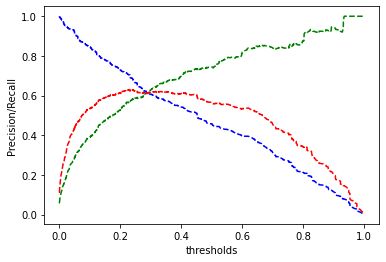

In [60]:
predictions_train = logmodel.predict(X_train_fit)
train_prob = logmodel.predict_proba(X_train_fit)
precision_train,recall_train,thresholds_train = precision_recall_curve(y_train_fit,train_prob[:,1])
f1_score_train = 2*precision_train*recall_train/(precision_train+recall_train)
plt.plot(thresholds_train, precision_train[: -1], "g--", label="Precision")
plt.plot(thresholds_train, recall_train[: -1], "b--", label="Recall")
plt.plot(thresholds_train,f1_score_train[: -1],"r--",label="F1Score")
plt.xlabel('thresholds')
plt.ylabel('Precision/Recall')

In [61]:
print(max(f1_score_train))
new_threshold = thresholds_train[np.argmax(f1_score_train)] #defining new threshold for logistic regression which maximises the f1_score
print(new_threshold)

0.631578947368421
0.22103692365669494


In [62]:
predictions_test = logmodel.predict(X_test_fit)
test_prob = logmodel.predict_proba(X_test_fit)
precision_test,recall_test,thresholds_test = precision_recall_curve(y_test_fit,test_prob[:,1])
f1_score_test = 2*precision_test*recall_test/(precision_test+recall_test)
print(max(f1_score_test))
new_threshold = thresholds_test[np.argmax(f1_score_test)]
print(new_threshold)

0.6523216308040769
0.22461339228179633


0.6998087954110899
0.577808939101029


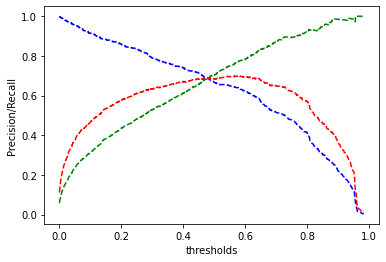

In [63]:
##using a neural netword model to maximize F1 score and find new threshold
nnmodel=MLPClassifier(solver='adam', learning_rate_init=0.009,alpha=0.3,hidden_layer_sizes=(10,50), random_state=1,max_iter=600)
nnmodel.fit(X_train_fit,y_train_fit)
train_prob = nnmodel.predict_proba(X_train_fit)
precision_train,recall_train,thresholds_train = precision_recall_curve(y_train_fit,train_prob[:,1])
f1_score_train = 2*precision_train*recall_train/(precision_train+recall_train)
plt.plot(thresholds_train, precision_train[: -1], "g--", label="Precision")
plt.plot(thresholds_train, recall_train[: -1], "b--", label="Recall")
plt.plot(thresholds_train,f1_score_train[: -1],"r--",label="F1Score")
plt.xlabel('thresholds')
plt.ylabel('Precision/Recall')
print(max(f1_score_train))
new_threshold = thresholds_train[np.argmax(f1_score_train)] #defining new threshold for logistic regression which maximises the f1_score
print(new_threshold)

0.7000000000000001
0.5103293493861378


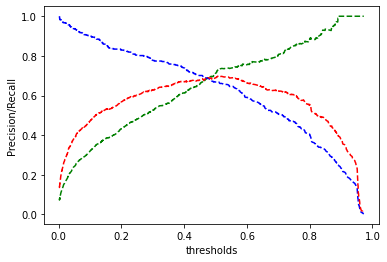

In [64]:
#calculating performance on the test set
test_prob = nnmodel.predict_proba(X_test_fit)
precision_test,recall_test,thresholds_test = precision_recall_curve(y_test_fit,test_prob[:,1])
f1_score_test = 2*precision_test*recall_test/(precision_test+recall_test)
plt.plot(thresholds_test, precision_test[: -1], "g--", label="Precision")
plt.plot(thresholds_test, recall_test[: -1], "b--", label="Recall")
plt.plot(thresholds_test,f1_score_test[: -1],"r--",label="F1Score")
plt.xlabel('thresholds')
plt.ylabel('Precision/Recall')
print(max(f1_score_test))
new_threshold = thresholds_test[np.argmax(f1_score_test)]
print(new_threshold)

In [65]:
#discussing example of using gridsearch to look for optimal hyperparameters, in this case alpha which is a regularization parameter
parameters = {'alpha':10.0 **-np.arange(1,7)}
print(parameters)

{'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06])}


In [66]:
clf = GridSearchCV(nnmodel,parameters,cv=5,scoring='f1')

In [67]:
clf.fit(X_train_fit,y_train_fit)

GridSearchCV(cv=5,
             estimator=MLPClassifier(alpha=0.3, hidden_layer_sizes=(10, 50),
                                     learning_rate_init=0.009, max_iter=600,
                                     random_state=1),
             param_grid={'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06])},
             scoring='f1')

In [68]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_alpha',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [69]:
clf.cv_results_['mean_test_score']


array([0.64505001, 0.62274313, 0.60539815, 0.6276775 , 0.64611421,
       0.61623937])